# Classification with XGBoost

## Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timeit

import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

Set the rng seed.

In [2]:
seed = 17

## Import and view data

In [3]:
df = pd.read_csv("data/train_prepd_3.csv")
display(df.head())
print('dims: ', df.shape)

,Survived,Pclass,Age,Fare,FamSize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_M,Deck_T
0,0.0,3,22.0,7.2500,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0
1,1.0,1,38.0,71.2833,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
2,1.0,3,26.0,7.9250,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
3,1.0,1,35.0,53.1000,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
4,0.0,3,35.0,8.0500,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0


dims:  (891, 20)


The XGBoost algorithm has default behaviour that can deal with missing data (if they are set to 0). However, I have already taken care of missing data in the EDA step.

In [4]:
df.isna().sum()

Survived       0
Pclass         0
Age            0
Fare           0
FamSize        0
Sex_male       0
Embarked_Q     0
Embarked_S     0
Title_Miss     0
Title_Mr       0
Title_Mrs      0
Title_Other    0
Deck_B         0
Deck_C         0
Deck_D         0
Deck_E         0
Deck_F         0
Deck_G         0
Deck_M         0
Deck_T         0
dtype: int64

## Split data into dependent and independent variables

In [5]:
# split into dependent and independent variables
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

## Build a preliminary model

In this step we'll build the most basic XGBoost model, to see what we can expect. First, we'll assess it on a simple train/test split, then using 10-fold cross-validation. 

In [6]:
np.mean(y)

0.3838383838383838

The dataset is fairly imbalanced (38% survived), so we'll use stratification in the train/test split. We'll also use stratification later on for cross validation.

In [7]:
# split into training and test sets, using stratification.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = seed)

Stratification check on y.

In [8]:
# Quick check to see if samples are indeed stratified.
print(np.mean(y_train))
print(np.mean(y_test))

0.38342696629213485
0.3854748603351955


Build the XGB classifier shell and fit it on the training data.

In [9]:
clf_prel = xgb.XGBClassifier(use_label_encoder=False, random_state=seed)
clf_prel.fit(X_train, y_train)

# Setting use_label_encoder=False is recommended by XGBoost.

[16:58:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=17,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

**NOTE**: In the model fit above, I could be using early stopping to prevent overfitting and improve performance - i.e. tell the algorithm to stop building more trees when the evaluation metric I choose (should be 'aucpr' here) is not improving on some holdout evaluation set (not the X_test, y_test). In the case of train/test splits, I should further split the train set into train and validation, then set early stopping criteria based on the performance gain on the validation set. In the case of CV (which occurs several times in the rest of the notebook) this is more difficult - each of the k train/test splits should really be a train/validation/test split, in order to assess early stopping on the validation set.

Intermingling early stopping with Grid Search / Randomized Search CV for hyperparameter tuning doesn't seem a great idea. 

https://stackoverflow.com/questions/48127550/early-stopping-with-keras-and-sklearn-gridsearchcv-cross-validation

Once I have the best hyperparameters through CV, I can always employ early stopping when fitting the model in the whole training set (provided of course that there is a separate validation set). Given the small size of the dataset for this project, I would prefer not to split further the training set just to employ early stopping.

A script is nonetheless constructed below. 

In [33]:
# # Split into train, validation and test sets in order to use early stopping.

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = seed)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=seed) # 0.25 x 0.8 = 0.2


# # Stratification check.

#print(np.mean(y_train))
#print(np.mean(y_test))
#print(np.mean(y_val))


# Build the XGB classifier shell and fit it on the training data. First, without early stopping. Evaluate on the validation set using AUC PR.

# **NOTE**: It is commonly seen to evaluate early stopping on the test set. This results in data leakage.

#clf_prel = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, random_state=seed)
#clf_prel.fit(X_train, 
#             y_train,
#             verbose=True,
#             #early_stopping_rounds=XX,
#             eval_metric='aucpr',
#             eval_set=[(X_train, y_train), (X_val, y_val)])

# # Setting use_label_encoder=False is recommended by XGBoost.

# # If multiple evaluation datasets or multiple evaluation metrics are provided, then early stopping will use the last in the list.


# Plot performance on the training set and on the validation set as more trees are built.

# results = clf_prel.evals_result()
# epochs = len(results['validation_0']['aucpr'])
# x_axis = range(0, epochs)
# # plot AUC PR
# fig, ax = plt.subplots()
# ax.plot(x_axis, results['validation_0']['aucpr'], label='Train')
# ax.plot(x_axis, results['validation_1']['aucpr'], label='Validation')
# ax.legend()
# plt.ylabel('AUC PR')
# plt.xlabel('Epochs')
# plt.title('XGBoost AUC PR')
# plt.show()


# Clearly the algorithm overfits quite fast. We will fit again using early stopping after no improvement is found on the validation set after 10 trees.

# clf_prel = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, random_state=seed)
# clf_prel.fit(X_train, 
#              y_train,
#              verbose=True,
#              early_stopping_rounds=10,
#              eval_metric='aucpr',
#              eval_set=[(X_train, y_train), (X_val, y_val)])

Accuracy: 82.12 %


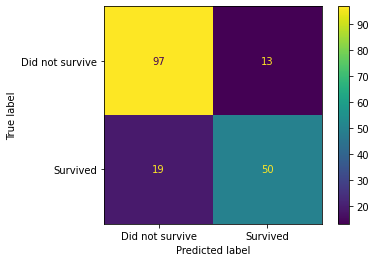

In [10]:
# predict on the test set
y_pred = clf_prel.predict(X_test)

# print accuracy and draw the confusion matrix
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy: {:.2f} %'.format(acc * 100))

plot_confusion_matrix(clf_prel, 
                     X_test,
                     y_test, display_labels=['Did not survive', 'Survived'])

Get a more robust estimation of the model accuracy, using repeated 10-fold stratified cross validation.

In [11]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)
scores = cross_val_score(clf_prel, X, y, cv=cv)

print('scores: ', scores )
print('Accuracy: {:.2f} %'.format(scores.mean() * 100))
print('St.dev: {:.4f}'.format(scores.std()))

[16:59:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[16:59:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:59:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

The preliminary model has an accuracy of 81.64%. We'll see if we can improve it with hypermarameter optimization.

The importance of the features in the XGB model is shown below:

Text(0.5, 0, 'Xgboost Feature Importance')

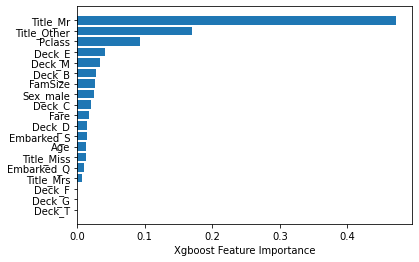

In [12]:
sorted_idx = clf_prel.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], clf_prel.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

## Hyperparameter tuning

We will use Grid Search CV (and Randomized Search CV) to find the best hyperparameters for XGBoost. Grid Search CV is going to be run within the entire training set and the model with the best average performance on the validation sets will be picked. Early stopping is not used (see note above).

In [13]:
# build the parameters dictionary
param_grid = {
    'max_depth': [4, 6, 8, 10], #increasing max depth further will likely improve performance, but will lead to overfitting.
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5], #learning rate 0.01 will likely overfit
    'gamma': [0, 0.25, 0.5, 1],
    'reg_lambda': [0, 1, 10, 20],
    'scale_pos_weight': [1, 2, 3, 4], #XGBoost recommends sum(negative instances) / sum(positive instances)
    'colsample_bytree': [0.3, 0.5, 0.8, 1],
    'min_child_weight': [1, 3, 5, 7]
}

In [14]:
# construct the XGB classifier shell and pass it to grid search along with the parameters dictionary
clf_gs = xgb.XGBClassifier(use_label_encoder=False, random_state=seed)
gs = GridSearchCV(clf_gs, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  n_jobs=-1, 
                  cv=5, 
                  verbose=2)

In [15]:
clf_rs = xgb.XGBClassifier(use_label_encoder=False, random_state=seed)
rs = RandomizedSearchCV(estimator=clf_rs,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        n_jobs=-1,
                        n_iter=500,
                        cv=5,
                        verbose=2,
                        random_state=seed)

First with Grid Search CV, which is exhaustive and more performance intensive.

In [22]:
#start timer
start = timeit.default_timer()

#run grid cv and print parameters
gs.fit(X, y)
print("Best Accuracy: {:.2f} %".format(gs.best_score_*100))
print("Best Parameters: ", gs.best_params_)

#end timer and print
stop = timeit.default_timer()
print('Time: {:.2f}'.format(stop - start)) 

Fitting 5 folds for each of 24576 candidates, totalling 122880 fits
[17:51:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Accuracy: 85.86 %
Best Parameters:  {'colsample_bytree': 0.5, 'gamma': 0.25, 'learning_rate': 0.3, 'max_depth': 10, 'min_child_weight': 5, 'reg_lambda': 0, 'scale_pos_weight': 1}
Time: 2906.53


In [21]:
# print results in a dataframe
pd.DataFrame(gs.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_min_child_weight,param_reg_lambda,param_scale_pos_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16352,0.409493,0.011451,0.002001,0.000002,0.8,0.5,0.2,10,5,0,1,"{'colsample_bytree': 0.8, 'gamma': 0.5, 'learn...",0.860335,0.831461,0.893258,0.837079,0.853933,0.855213,0.021764,1
16548,0.317328,0.015926,0.002402,0.000490,0.8,0.5,0.3,8,5,1,1,"{'colsample_bytree': 0.8, 'gamma': 0.5, 'learn...",0.843575,0.837079,0.887640,0.842697,0.853933,0.852985,0.018162,2
16288,0.294411,0.009195,0.002903,0.000199,0.8,0.5,0.2,8,5,0,1,"{'colsample_bytree': 0.8, 'gamma': 0.5, 'learn...",0.854749,0.831461,0.882022,0.837079,0.859551,0.852972,0.017920,3
720,0.284068,0.003432,0.002803,0.000400,0.3,0,0.1,10,3,0,1,"{'colsample_bytree': 0.3, 'gamma': 0, 'learnin...",0.832402,0.848315,0.870787,0.837079,0.870787,0.851874,0.016286,4
19300,0.264641,0.002247,0.002402,0.000490,1,0,0.2,6,5,1,1,"{'colsample_bytree': 1, 'gamma': 0, 'learning_...",0.854749,0.831461,0.870787,0.831461,0.870787,0.851849,0.017647,5


Then with Randomized Search CV, which samples the hypermarameter combinations and should be much faster.

In [16]:
#start timer
start = timeit.default_timer()

#run grid cv and print parameters
rs.fit(X, y)
print("Best Accuracy: {:.2f} %".format(rs.best_score_*100))
print("Best Parameters: ", rs.best_params_)

#end timer and print
stop = timeit.default_timer()
print('Time: {:.2f}'.format(stop - start))

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[17:01:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Accuracy: 85.30 %
Best Parameters:  {'scale_pos_weight': 1, 'reg_lambda': 0, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0.5, 'colsample_bytree': 0.8}
Time: 64.68


In [18]:
# print results in a dataframe
pd.DataFrame(rs.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scale_pos_weight,param_reg_lambda,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
310,0.311046,0.008292,0.002501,0.000449,1,20,5,10,0.5,0,0.8,"{'scale_pos_weight': 1, 'reg_lambda': 20, 'min...",0.832402,0.825843,0.887640,0.848315,0.859551,0.850750,0.021915,1
56,0.365532,0.004712,0.002803,0.000400,1,1,3,8,0.1,0,0.5,"{'scale_pos_weight': 1, 'reg_lambda': 1, 'min_...",0.832402,0.837079,0.882022,0.837079,0.859551,0.849627,0.018759,2
80,0.289863,0.014093,0.002803,0.000400,1,20,7,8,0.5,0,0.8,"{'scale_pos_weight': 1, 'reg_lambda': 20, 'min...",0.843575,0.820225,0.882022,0.842697,0.853933,0.848490,0.020053,3
29,0.343614,0.012314,0.002602,0.000490,1,1,5,8,0.3,0.25,0.8,"{'scale_pos_weight': 1, 'reg_lambda': 1, 'min_...",0.821229,0.831461,0.887640,0.837079,0.853933,0.846268,0.023243,4
438,0.269981,0.010226,0.002803,0.000400,1,0,3,10,0.3,0.25,0.3,"{'scale_pos_weight': 1, 'reg_lambda': 0, 'min_...",0.837989,0.831461,0.865169,0.825843,0.870787,0.846249,0.018239,5


## Final XGBoost model and evaluation on the test set

Here we build the final XGB model, with the optimized hyperparameters from Grid Search CV. 

In [23]:
clf = xgb.XGBClassifier(colsample_bytree=0.5,
                        gamma=0.25,
                        learning_rate=0.3,
                        max_depth=10,
                        min_child_weight=5,
                        reg_lambda=0,
                        scale_pos_weight=1,
                        use_label_encoder=False,
                        random_state=seed
                        )
clf.fit(X_train, y_train)

[19:02:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=10,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=17,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Text(0.5, 0, 'Xgboost Feature Importance')

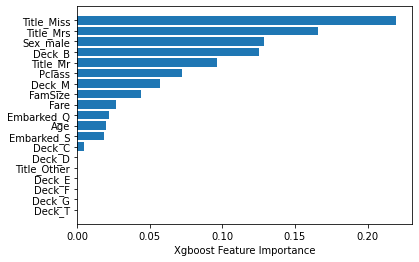

In [24]:
sorted_idx = clf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

Accuracy: 84.92 %


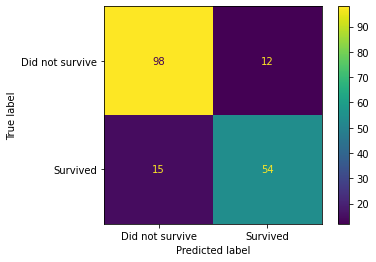

In [25]:
# predict on the test set
y_pred = clf.predict(X_test)

# print accuracy and draw the confusion matrix
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy: {:.2f} %'.format(acc * 100))

plot_confusion_matrix(clf, 
                     X_test,
                     y_test, display_labels=['Did not survive', 'Survived'])

Finally, evaluate the performance using repeated 10-fold stratified cross validation:

In [26]:
# Create the cv tactic (repeated and stratified 10-fold).
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

# Get the scores and return the output.
scores = cross_val_score(clf, X, y, cv=cv)

print('scores: ', scores )
print('Accuracy: {:.2f} %'.format(scores.mean() * 100))
print('St.dev: {:.4f}'.format(scores.std()))

[19:03:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:03:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:03:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:03:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[19:03:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:03:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:03:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:03:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

Text(0.5, 0, 'Xgboost Feature Importance')

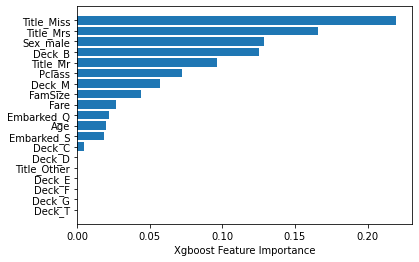

In [27]:
sorted_idx = clf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

CV results show that we can expect an accuracy of 84% from the final tuned XGB model.